In [1]:
#pip install -e .

Obtaining file:///Users/pierrejunca/code/Dekkerz/mocap
  Preparing metadata (setup.py) ... done
  Using cached jupyter-1.0.0-py2.py3-none-any.whl (2.7 kB)
ERROR: Could not find a version that satisfies the requirement tensorflow (from mocap) (from versions: none)
ERROR: No matching distribution found for tensorflow

[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re

from scipy import stats

from keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

from keras.layers import  Dense, Dropout, Flatten, Reshape, LSTM, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

from tensorflow import keras
from tensorflow.keras.metrics import Recall, Precision

import seaborn as sns

In [28]:
xls_dir="UT_Smoking_Data"

df=None
for f_in in [1, 2, 3, 4, 5, 6, 7, 8]: 
  P1_Data_path = os.path.join(xls_dir+"/" + "Participant"+str(f_in)+"_Data.xlsx")
  try:
    if df is not None :
      df2 = pd.read_excel(P1_Data_path, header=None, nrows=None)
      df=pd.concat([df, df2], ignore_index=True, axis=0)
    else :  
      df = pd.read_excel(P1_Data_path, header=None, nrows=None)
    print("concat {} ok".format(P1_Data_path, len(df))) 
  except :
     print("pb with {}".format(P1_Data_path)) 
                              
df_train=df.copy(); del(df)
                              
df=None
for f_in in [9, 11]:
  P1_Data_path = os.path.join(xls_dir+"/" + "Participant"+str(f_in)+"_Data.xlsx")
  try:
    if df is not None :
      df2 = pd.read_excel(P1_Data_path, header=None, nrows=None)
      df=pd.concat([df, df2], ignore_index=True, axis=0)
    else :  
      df = pd.read_excel(P1_Data_path, header=None, nrows=None)
    print("concat {} ok".format(P1_Data_path, len(df))) 
  except :
     print("pb with {}".format(P1_Data_path))  
                              
df_test=df.copy(); del(df)                           

concat UT_Smoking_Data/Participant1_Data.xlsx ok
concat UT_Smoking_Data/Participant2_Data.xlsx ok
concat UT_Smoking_Data/Participant3_Data.xlsx ok
concat UT_Smoking_Data/Participant4_Data.xlsx ok
concat UT_Smoking_Data/Participant5_Data.xlsx ok
concat UT_Smoking_Data/Participant6_Data.xlsx ok
concat UT_Smoking_Data/Participant7_Data.xlsx ok
concat UT_Smoking_Data/Participant8_Data.xlsx ok
concat UT_Smoking_Data/Participant9_Data.xlsx ok
concat UT_Smoking_Data/Participant11_Data.xlsx ok


In [29]:
d = {0:'timestamp_WD', 
     1:'Accelerometer_x_WD', 2:'Accelerometer_y_WD', 3:'Accelerometer_z_WD', 
     4:'Linear_acceleration_sensor_x_WD', 5:'Linear_acceleration_sensor_y_WD', 6:'Linear_acceleration_sensor_z_WD', 
     7:'Gyroscope_x_WD', 8:'Gyroscope_y_WD', 9:'Gyroscope_z_WD',
    10:'Magnetometer_x_WD', 11:'Magnetometer_y_WD', 12:'Magnetometer_z_WD', 
     13:'Pressure_sensor_WD', 14:'Heart_rate_sensor_WD',
    15:'GAP', 
     16:'timestamp_PD', 
     17:'Accelerometer_x_PD', 18:'Accelerometer_y_PD', 19:'Accelerometer_z_PD',
    20:'Linear_acceleration_sensor_x_PD', 21:'Linear_acceleration_sensor_y_PD', 22:'Linear_acceleration_sensor_z_PD', 
     23:'Gyroscope_x_PD', 24:'Gyroscope_y_PD',25:'Gyroscope_z_PD', 
     26:'Magnetometer_x_PD', 27:'Magnetometer_y_PD', 28:'Magnetometer_z_PD', 
     29:'GPS_lat_PD',30:'GPS_long_PD', 
     31:'Class_label'}

In [30]:
label_class = {'SmokeSD':0
                ,'SmokeST':1
                ,'Eat':2
                ,'DrinkSD':3
                ,'DrinkST':4
                ,'Sit':5
                ,'Stand':6
                }

In [31]:
train_data = df_train.rename(d, axis=1)
train_data['Class'] = train_data['Class_label'].map(label_class)

test_data = df_test.rename(d, axis=1)
test_data['Class'] = test_data['Class_label'].map(label_class)

In [32]:
def scrub_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    clean raw data by removing buggy or irrelevant transactions
    or columns for the training set
    """
    participant_num=''.join([d for d in re.findall(r'\d+',"")])
    df['Participant_Num']=participant_num

    # remove useless/redundant columns
    df = df.drop(columns=['timestamp_WD'
                    ,'GAP'
                    ,'timestamp_PD'
                    ,'Accelerometer_x_PD'
                    ,'Accelerometer_y_PD'
                    ,'Accelerometer_z_PD'
                    ,'Linear_acceleration_sensor_x_PD'
                    ,'Linear_acceleration_sensor_y_PD'
                    ,'Linear_acceleration_sensor_z_PD'
                    ,'Gyroscope_x_PD'
                    ,'Gyroscope_y_PD'
                    ,'Gyroscope_z_PD'
                    ,'Magnetometer_x_PD'
                    ,'Magnetometer_y_PD'
                    ,'Magnetometer_z_PD'
                    ,'GPS_lat_PD'
                    ,'GPS_long_PD'])

    print("\n✅ data cleaned")

    return df

In [33]:
train_data = scrub_data(train_data)
test_data = scrub_data(test_data)


✅ data cleaned

✅ data cleaned


In [35]:
import pickle

x_obj_fname=xls_dir+"/" + "pierre_train"+str(f_in)+".pickle"
data_file = open(x_obj_fname, 'wb')
pickle.dump(train_data, data_file)
data_file.close()

x_obj_fname=xls_dir+"/" + "pierre_test"+str(f_in)+".pickle"
data_file = open(x_obj_fname, 'wb')
pickle.dump(test_data, data_file)
data_file.close()

In [36]:
def create_segments_and_labels(df, time_steps, step):

    # x, y, z acceleration as features
    n_features = 3
    # Each generated sequence contains 200 training examples
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['Accelerometer_x_WD'].values[i: i + time_steps]
        ys = df['Accelerometer_y_WD'].values[i: i + time_steps]
        zs = df['Accelerometer_z_WD'].values[i: i + time_steps]
        # Retrieve the most often used label in each segment
        label = stats.mode(df['Class'][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, n_features)
    labels =np.asarray(pd.get_dummies(labels), dtype = np.float32)

    return reshaped_segments, labels

In [37]:
reshaped_segments_test, labels_test = create_segments_and_labels(test_data, 1500, 500) #df, time_steps, step
print(reshaped_segments_test.shape, labels_test.shape)

reshaped_segments_train, labels_train = create_segments_and_labels(train_data, 1500, 500) #df, time_steps, step
print(reshaped_segments_train.shape, labels_train.shape)

/tmp/ipykernel_14282/1238486949.py:13: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['Class'][i: i + time_steps])[0][0]


(1803, 1500, 3) (1803, 7)
(10545, 1500, 3) (10545, 7)


In [44]:

X_train_res, X_train_val, y_train_res, y_train_val = train_test_split(reshaped_segments_train, 
                                                                    labels_train, test_size=0.1, 
                                                                    random_state=42)

X_test_res=reshaped_segments_test
y_test_res=labels_test

num_time_periods, num_sensors = X_train_res.shape[1], X_train_res.shape[2]
input_shape = (num_time_periods*num_sensors)
print('input_shape:', input_shape)

num_classes = 7
print('input_shape:', input_shape)


#X_train_val = X_train_res.reshape(X_train_res.shape[0], input_shape)
#X_test_val = X_test_res.reshape(X_test_res.shape[0], input_shape)
#X_train_val= X_train_val.astype('float32')
#y_train_val = y_train_res.astype('float32')
#X_test_val = X_test_val.astype('float32')
#y_test_val = y_test_res.astype('float32')

input_shape: 4500
input_shape: 4500


In [45]:
num_classes = 7
time_steps = 1500
input_shape = X_train_res.shape[1:]
n_neuron= 100
print(input_shape)

(1500, 3)


In [46]:
print('x_train shape:', X_train_res.shape)
print('y_train shape:', y_train_res.shape)
print('\n')

print('x_train_val shape:', X_train_val.shape)
print('y_train_val shape:', y_train_val.shape)
print('\n')

print('x_test shape:', X_test_res.shape)
print('y_test shape:', y_test_res.shape)

# Set input & output dimensions
num_time_periods, num_sensors = X_train_res.shape[1], X_train_res.shape[2]
num_classes = 7

x_train shape: (9490, 1500, 3)
y_train shape: (9490, 7)


x_train_val shape: (1055, 1500, 3)
y_train_val shape: (1055, 7)


x_test shape: (1803, 1500, 3)
y_test shape: (1803, 7)


In [47]:
do_this=False

# summarize history for accuracy
if do_this :
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [48]:
lstm_neurons= 100
dense_neurons= 100
drop_out= 0.5

In [49]:
def make_cnn_lstm_model(lstm_neurons,dense_neurons,drop_out):
    
    metrics = [  keras.metrics.Recall(), 
                 keras.metrics.Precision(),
                 keras.metrics.AUC(name='prc', curve='PR') ]
    
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'),  input_shape=(n_steps,n_length, 3)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(drop_out)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(lstm_neurons))
    model.add(Dropout(drop_out)) 
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
    
    return model

In [50]:
# reshape data into time steps of sub-sequences
n_steps, n_length = 150,10

X_train_cnn = X_train_res.reshape((X_train_res.shape[0], n_steps, n_length, 3))
X_train_val_cnn = X_train_val.reshape((X_train_val.shape[0], n_steps, n_length, 3))
X_test_cnn = X_test_res.reshape((X_test_res.shape[0], n_steps, n_length, 3))

In [51]:
try:
  del model_cnn_lstm
except:
  pass

model_cnn_lstm = make_cnn_lstm_model(lstm_neurons= 100, dense_neurons = 100, drop_out = 0.5)
print(model_cnn_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 150, 8, 64)       640       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 150, 6, 64)       12352     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 150, 6, 64)       0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 150, 3, 64)       0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 150, 192)         0

In [52]:
X_train_cnn.shape

(9490, 150, 10, 3)

In [53]:
es = EarlyStopping(monitor="val_loss",
                       patience=5,
                       restore_best_weights=True,
                       verbose=0)

cnn_lstm = model_cnn_lstm.fit(X_train_cnn, y_train_res, batch_size=64,
                      epochs=50, callbacks=[es], validation_data=(X_train_val_cnn, y_train_val) ,verbose=1)

Epoch 1/50
149/149 [==============================] - 55s 337ms/step - loss: 1.3254 - recall: 0.2248 - precision: 0.8160 - prc: 0.5338 - val_loss: 1.3378 - val_recall: 0.1886 - val_precision: 0.6700 - val_prc: 0.4915
Epoch 2/50
149/149 [==============================] - 56s 379ms/step - loss: 1.0007 - recall: 0.4267 - precision: 0.7855 - prc: 0.6994 - val_loss: 1.3049 - val_recall: 0.3555 - val_precision: 0.6178 - val_prc: 0.5573
Epoch 3/50
149/149 [==============================] - 68s 454ms/step - loss: 0.8067 - recall: 0.5607 - precision: 0.7853 - prc: 0.7833 - val_loss: 0.9507 - val_recall: 0.5763 - val_precision: 0.7062 - val_prc: 0.7261
Epoch 4/50
149/149 [==============================] - 58s 390ms/step - loss: 0.7086 - recall: 0.6354 - precision: 0.7919 - prc: 0.8232 - val_loss: 0.8856 - val_recall: 0.6114 - val_precision: 0.7223 - val_prc: 0.7650
Epoch 5/50
149/149 [==============================] - 59s 394ms/step - loss: 0.6088 - recall: 0.6947 - precision: 0.8107 - prc: 0.85

In [55]:
model_cnn_lstm.save("pierre_model_8_2")

INFO:tensorflow:Assets written to: pierre_model_8_2/assets


INFO:tensorflow:Assets written to: pierre_model_8_2/assets


In [56]:
def plot_history(history, optimizer_str, axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    
    pkey="precision"; vpkey="val_precision"
    for key in history.history.keys():
      if key.startswith("precision")       : pkey=key; 
      elif key.startswith("val_precision") : vpkey=key; 
        
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()
               
    ax2.plot(history.history[pkey], label='train accuracy'  + exp_name)
    ax2.plot(history.history[vpkey], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy ' + optimizer_str)
    ax2.legend()
    return (ax1, ax2)

(<AxesSubplot: title={'center': 'loss'}>,
 <AxesSubplot: title={'center': 'Accuracy adam'}>)

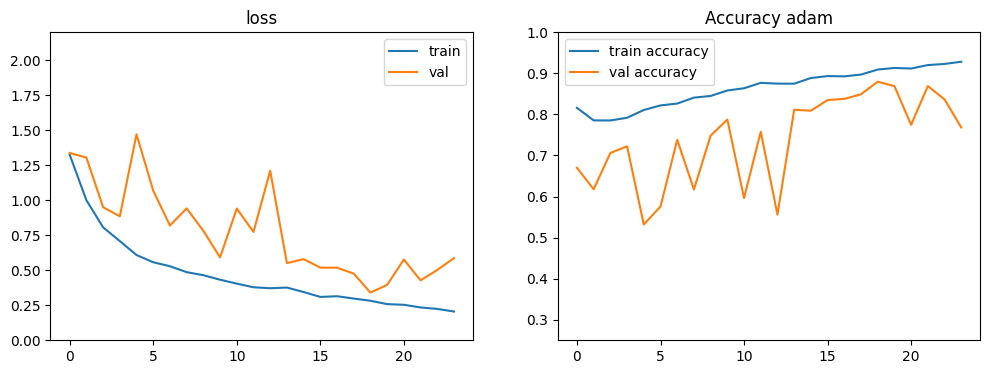

In [57]:
plot_history(cnn_lstm, "adam")

In [58]:
# Print confusion matrix for training data
y_pred_train = model_cnn_lstm.predict(X_train_cnn)

# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
max_train = np.argmax(y_train_res, axis=1)

print(classification_report(max_train, max_y_pred_train))

297/297 [==============================] - 22s 71ms/step
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1360
           1       0.89      0.81      0.85      1343
           2       0.98      0.96      0.97      1343
           3       0.77      0.68      0.72      1370
           4       0.69      0.88      0.78      1353
           5       0.98      0.98      0.98      1359
           6       1.00      0.99      1.00      1362

    accuracy                           0.88      9490
   macro avg       0.89      0.88      0.88      9490
weighted avg       0.89      0.88      0.88      9490



In [59]:
score = model_cnn_lstm.evaluate(X_test_cnn, y_test_res, verbose=1)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

57/57 [==============================] - 4s 70ms/step - loss: 0.9654 - recall: 0.6866 - precision: 0.6979 - prc: 0.8012

Accuracy on test data: 0.69

Loss on test data: 0.97


In [60]:
def confusion_matrix_plot(y, y_pred):
    labels=['SmokeSD', 'SmokeST', 'Eat', 'DrinkSD', 'DrinkST', 'Sit', 'Stand']
    matrix = metrics.confusion_matrix(y, y_pred)
    plt.figure(figsize=(9, 7))
    ax= sns.heatmap(matrix, cmap='coolwarm', linecolor='white', linewidths=1, xticklabels=labels, yticklabels=labels, annot=True, fmt='d')
    #bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

57/57 [==============================] - 4s 64ms/step
              precision    recall  f1-score   support

           0       0.89      0.59      0.71       257
           1       0.82      0.29      0.43       258
           2       0.97      0.74      0.84       258
           3       0.34      0.31      0.32       258
           4       0.43      0.98      0.60       258
           5       0.93      0.97      0.95       256
           6       0.99      0.99      0.99       258

    accuracy                           0.69      1803
   macro avg       0.77      0.69      0.69      1803
weighted avg       0.77      0.69      0.69      1803



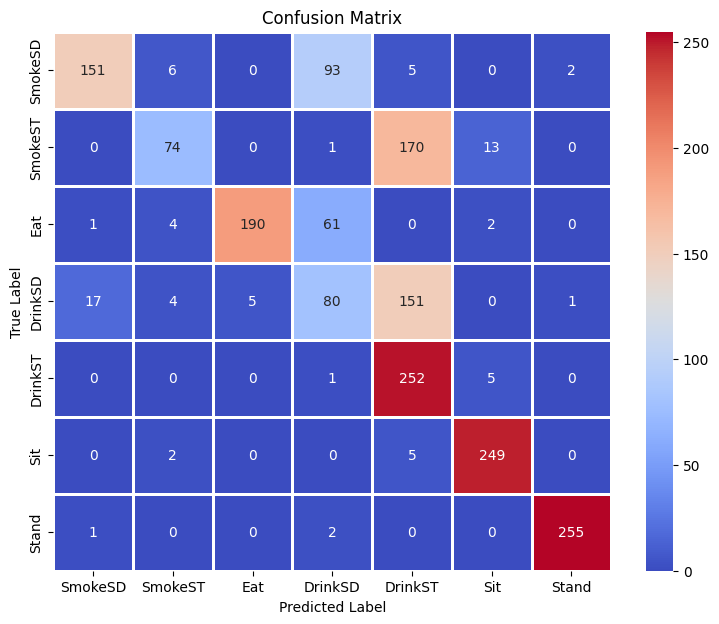

In [61]:
# Take the class with the highest probability from the test predictions
y_pred_test = model_cnn_lstm.predict(X_test_cnn)

max_y_pred_test = np.argmax(y_pred_test, axis = 1)
max_y_test = np.argmax(y_test_res, axis = 1)

#confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))
confusion_matrix_plot(max_y_test, max_y_pred_test)

In [62]:
max_y_pred_test.shape

(1803,)

In [63]:
max_y_test.shape

(1803,)